**Machine Learning for Time Series (Master MVA)**

- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

$$\textbf{Convolutional Dictionary Learning & Dynamic Time Warping}$$





1.   List item
2.   List item



**Objective**: The goal is to learn to apply the convolutional dictionary learning procedure and the dynamic time warping distance on the real medical application.



---

- See Convolutional Dictionary Learning & Dynamic Time Warping Assignment first.


# Setup

**Imports**

In [ ]:
import numpy as np
from scipy.signal import argrelmax
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

In [ ]:
THRESHOLD_IoU = 0.75

**Utility functions**

In [ ]:
def _check_step_list(step_list):
    """Some sanity checks."""
    for step in step_list:
        assert len(step) == 2, f"A step consists of a start and an end: {step}."
        start, end = step
        assert start < end, f"start should be before end: {step}."

In [ ]:
def inter_over_union(interval_1, interval_2):
    """Intersection over union for two intervals."""
    a, b = interval_1
    c, d = interval_2
    intersection = max(0, min(b, d) - max(a, c))
    if intersection > 0:
        union = max(b, d) - min(a, c)
    else:
        union = (b - a) + (d - c)
    return intersection / union

In [ ]:
def _step_detection_precision(step_list_true, step_list_pred):
    """Precision is the number of correctly predicted steps divided by the number of predicted
    steps. A predicted step is counted as correct if it overlaps an annotated step (measured by the
    "intersection over union" metric) by more than 75%.
    Note that an annotated step can only be detected once. If several predicted steps correspond
    to the same annotated step, all but one are considered as false.
    Here, precision is computed on a single prediction task (all steps correspond to the same
    signal).
    The lists y_true_ and y_pred are lists of steps, for instance:
        - step_list_true: [[357, 431], [502, 569], [633, 715], [778, 849], [907, 989]]
        - step_list_pred: [[293, 365], [422, 508], [565, 642], [701, 789]]
    Arguments:
        step_list_true {List} -- list of true steps
        step_list_pred {List} -- list of predicted steps
    Returns:
        float -- precision, between 0.0 and 1.0
    """
    _check_step_list(step_list_pred)

    if len(step_list_pred) == 0:  # empty prediction
        return 0.0

    n_correctly_predicted = 0
    detected_index_set = set()  # set of index of detected true steps
    for step_pred in step_list_pred:
        for (index, step_true) in enumerate(step_list_true):
            if (index not in detected_index_set) and (
                inter_over_union(step_pred, step_true) > THRESHOLD_IoU
            ):
                n_correctly_predicted += 1
                detected_index_set.add(index)
                break
    return n_correctly_predicted / len(step_list_pred)

In [ ]:
def _step_detection_recall(step_list_true, step_list_pred):
    """Recall is the number of detected annotated steps divided by the total number of annotated
    steps. An annotated step is counted as detected if it overlaps a predicted step (measured by
    the "intersection over union" metric) by more than 75%.
    Note that an annotated step can only be detected once. If several annotated steps are detected
    with the same predicted step, all but one are considered undetected.
    Here, recall is computed on a single prediction task (all steps correspond to the same
    signal).
    The lists y_true_ and y_pred are lists of steps, for instance:
        - step_list_true: [[357, 431], [502, 569], [633, 715], [778, 849], [907, 989]]
        - step_list_pred: [[293, 365], [422, 508], [565, 642], [701, 789]]
    Arguments:
        step_list_true {List} -- list of true steps
        step_list_pred {List} -- list of predicted steps
    Returns:
        float -- recall, between 0.0 and 1.0
    """
    _check_step_list(step_list_pred)

    n_detected_true = 0
    predicted_index_set = set()  # set of indexes of predicted steps

    for step_true in step_list_true:
        for (index, step_pred) in enumerate(step_list_pred):
            if (index not in predicted_index_set) and (
                inter_over_union(step_pred, step_true) > THRESHOLD_IoU
            ):
                n_detected_true += 1
                predicted_index_set.add(index)
                break
    return n_detected_true / len(step_list_true)

In [ ]:
def f1_score_step_detection(y_true, y_pred) -> float:
    """
    Calculate f-score (geometric mean between precision and recall) for each instance (each
    signal) and return the weighted average over instances.
    The lists y_true_ and y_pred are lists of lists of steps, for instance:
        - y_true: [[[907, 989]] [[357, 431], [502, 569]], [[633, 715], [778, 849]]]
        - y_pred: [[[293, 365]], [[422, 508], [565, 642]], [[701, 789]]]
    Arguments:
        y_true {List} -- true steps
        y_pred {List} -- predicted steps
    Returns:
        float -- f-score, between 0.0 and 1.0
    """
    # to prevent throwing an exception when passing empty lists
    if len(y_true) == 0:
        return 0

    fscore_list = list()

    for (step_list_true, step_list_pred) in zip(y_true, y_pred):
        prec = _step_detection_precision(step_list_true, step_list_pred)
        rec = _step_detection_recall(step_list_true, step_list_pred)
        if prec + rec < 1e-6:
            fscore_list.append(0.0)
        else:
            fscore_list.append((2 * prec * rec) / (prec + rec))

    return np.mean(fscore_list)

In [ ]:
def sparsify_codes(z_1D, atom_length: int):
    """Set to zero codes that are too close to each others.

    Keep only the (local) maximum code and set to zero codes that are less than
    `atom_length` away.
    `z_1D` is assumed to be univariate.
    """
    res = np.zeros_like(z_1D)
    argmax_indexes,_ = argrelmax(z_1D, order=atom_length)
    res[argmax_indexes] = z_1D[argmax_indexes]
    return res


def sparse_codes_to_list_of_steps(z_1D, atom_length: int):
    """Return a list of steps from a 1D activation vector."""
    z_1D_sparser = sparsify_codes(z_1D=z_1D, atom_length=atom_length)
    start_array,_ = np.nonzero(z_1D_sparser)
    end_array = start_array + atom_length
    return np.c_[start_array, end_array].tolist()

In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Convolutional dictionary learning (CDL)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [ ]:
subset_indexes_train = [851, 428, 739, 621, 147, 281, 95, 619, 441, 149, 951, 803, 214, 754, 34, 516, 684, 514, 465, 675, 654, 665, 297, 217, 618, 37, 954, 888, 630, 839, 897, 146, 559, 896, 941, 93, 658, 674, 78, 498, 575, 525, 36, 313, 300, 710, 56, 460, 397, 943]
subset_indexes_test = [683, 259, 59, 387, 634, 611, 87, 201, 86, 849, 538, 962, 205, 15, 883, 42]

code_list = get_code_list()

X_train = list()  # list of signals
y_train = list()  # list of list of steps (the "labels")
list_of_pathologies_train = list()

X_test = list()  # list of signals
y_test = list()  # list of list of steps (the "labels")
list_of_pathologies_test = list()


for (X, y, list_of_pathologies, subset_indexes) in zip([X_train, X_test], [y_train, y_test], [list_of_pathologies_train, list_of_pathologies_test], [subset_indexes_train, subset_indexes_test]):
    for code in np.take(code_list, subset_indexes):
        single_trial = load_human_locomotion_dataset(code)
        signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
        steps = single_trial.left_steps
        X.append(signal[:2000])  # truncate signals to have the same length
        y.append(steps[(steps<2000).prod(axis=1).astype(bool)])
        list_of_pathologies.append(single_trial.metadata["PathologyGroup"])

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

100%|███████████████████████████████████████| 202M/202M [01:43<00:00, 1.95MiB/s]


Display one signal. Notice the repetitive patterns: those are the footsteps to detect.

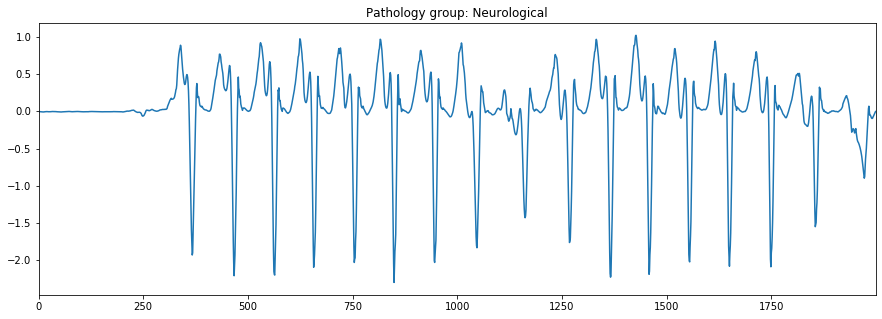

In [ ]:
ind = 45  # choose a signal
(signal, steps, pathology) = X_train[ind], y_train[ind], list_of_pathologies_train[ind]

# plotting and saving the figure
fig, ax = fig_ax()
ax.plot(signal)
_ = ax.set_title(f"Pathology group: {pathology}")

## Question 3

In [ ]:
from alphacsc import learn_d_z
from alphacsc.utils import construct_X

In [ ]:
reg = 0.5
K = 5
L = 90

V_0/50 .................................................


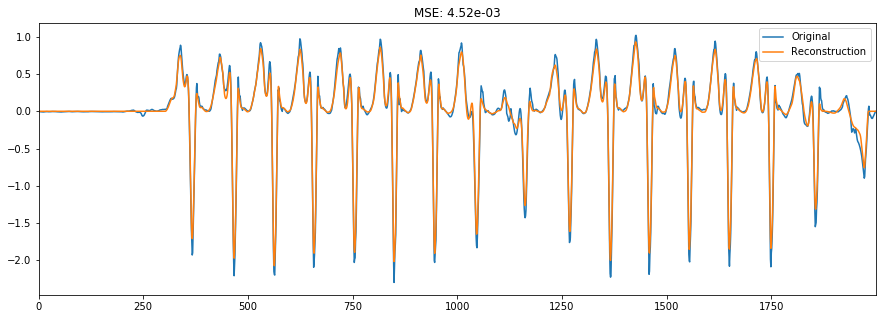

In [ ]:
ind = 45  # choose a signal
(signal, steps, pathology) = X_train[ind], y_train[ind], list_of_pathologies_train[ind]

### Change this part (at least)
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=signal[np.newaxis,:],
    n_atoms=K,
    n_times_atom=L,
    reg=reg,
    n_iter=50,
    n_jobs=1,
    verbose=1)
reconstruction = construct_X(z_hat, d_hat).squeeze()
mse = np.mean((signal - reconstruction)**2)
###

# plotting and saving the figure
fig, ax = fig_ax()
ax.set_title(f"MSE: {mse:.2e}")
ax.plot(signal, label="Original")
ax.plot(reconstruction, label="Reconstruction")
plt.legend()
# saving the figure
plt.savefig(fname="figure-question-3.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

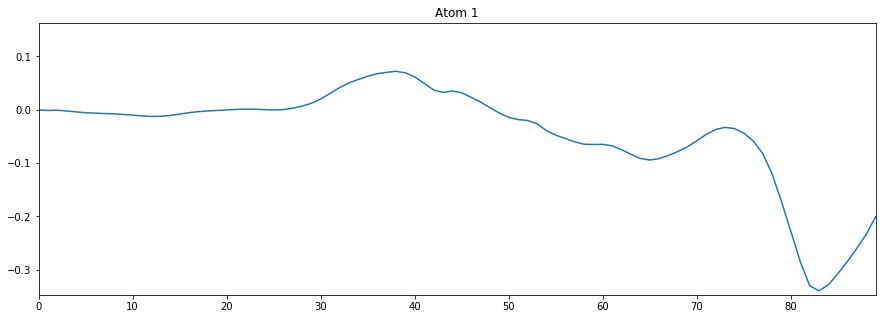

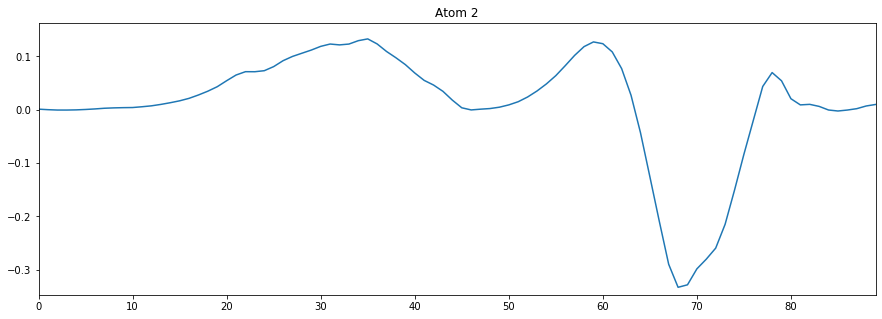

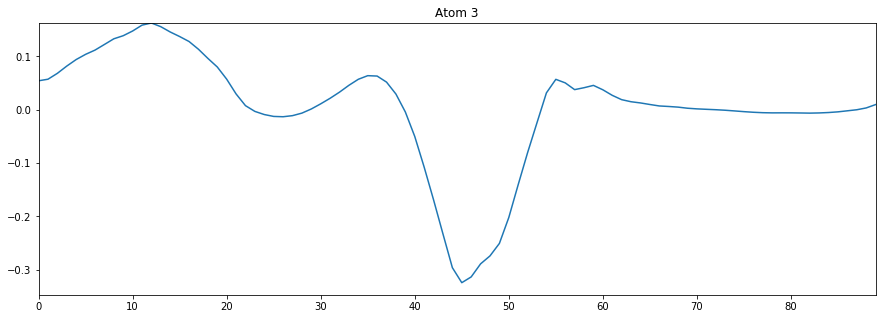

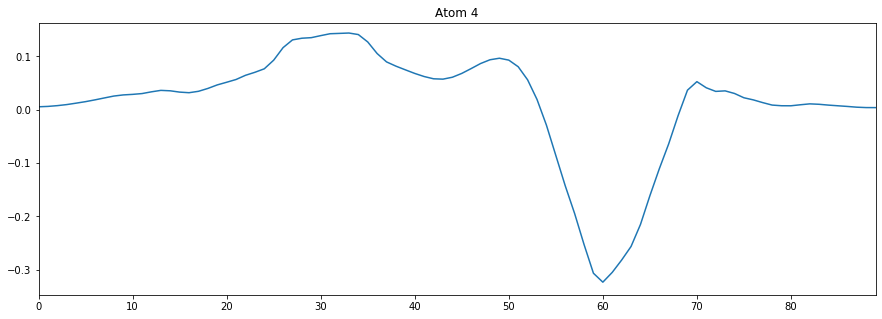

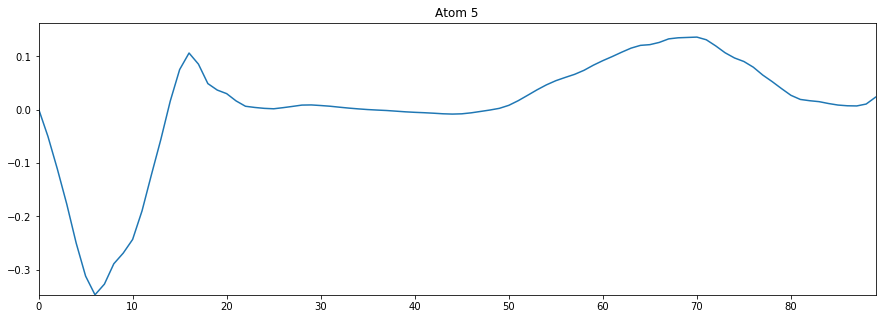

In [ ]:
# Plotting atoms

D = d_hat.T.squeeze()

for k in range(K):
    fig, ax = fig_ax()
    ax.plot(D[:,k], label="Original")
    ax.set_title(f"Atom {k+1}")
    plt.ylim((np.min(D), np.max(D)))
    plt.savefig(fname=f"Atom-{k+1}.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

In [ ]:
# F1 score

pred_steps = np.array(sparse_codes_to_list_of_steps(z_hat.T.squeeze(), L))
F1 = f1_score_step_detection(steps[np.newaxis,:,:], pred_steps[np.newaxis,:,:])
print("F1 score is equal to: {:.2f}".format(F1))

F1 score is equal to: 0.37


## Question 4

Hints:
- For ease of use, code a scikit-learn estimator class `ConvDL` that implements
    - `.fit()` (learn dictionary),
    - `.predict()` method (return a list of list of steps). Use the helper function `sparse_codes_to_list_of_steps`.
- In the cross-validation, use the `f1_score_step_detection` function to compute the F-score between prediction and label.

In [ ]:
from alphacsc import learn_d_z
from alphacsc.update_z import update_z
from sklearn.base import BaseEstimator

class ConvDL(BaseEstimator):

    def __init__(self, reg=None, n_atoms=None, atom_length=None, n_iter=30):
        self.reg = reg
        self.n_atoms = n_atoms
        self.atom_length = atom_length
        self.n_iter = n_iter
        self.d_hat = None

    def fit(self, X, y=None):
        _, _, self.d_hat, z_hat, _ = learn_d_z(
            X=X,
            n_atoms=self.n_atoms,
            n_times_atom=self.atom_length,
            reg=self.reg,
            n_iter=self.n_iter,
            n_jobs=1,
            lmbd_max="scaled",
            verbose=1)
        return self.d_hat, z_hat

    def predict(self, X):
        assert self.d_hat is not None, "Model has yet to be trained."
        z_hat = update_z(
            X=X,
            ds=self.d_hat,
            reg=self.reg)
        n = z_hat.shape[1]
        return [np.array(sparse_codes_to_list_of_steps(z_hat[:,i,:].T, self.atom_length)) for i in range(n)]

Use helper functions from scikit-learn to find the optimal combination of parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# list of values for lambda as a percentage of lambda_max (see Question 2)
# use the argument `lmbd_max="scaled"` in alphacsc.learn_d_z
penalty_list = [0.1, 0.2, 0.5, 0.8, 0.9, 0.95]

# list of values for K
n_atoms_list = [2, 4, 6, 8, 10, 20]

# list of values for L
atom_length_list = [20, 50, 80, 100, 150]

In [ ]:
parameters = {'reg':penalty_list, 'n_atoms':n_atoms_list, "atom_length":atom_length_list}

model = ConvDL()
scorer = make_scorer(f1_score_step_detection)

gs = GridSearchCV(model, parameters, scoring=scorer, cv=5)

In [ ]:
# use X_train and y_train

gs.fit(X_train, y_train)

V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V

V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V

V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................
V_0/30 .............................


GridSearchCV(cv=5, estimator=ConvDL(),
             param_grid={'atom_length': [20, 50, 80, 100, 150],
                         'n_atoms': [2, 4, 6, 8, 10, 20],
                         'reg': [0.1, 0.2, 0.5, 0.8, 0.9, 0.95]},
             scoring=make_scorer(f1_score_step_detection))

In [ ]:
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

print("Best parameters set found: %r"%gs.best_params_)
print()
means = gs.cv_results_["mean_test_score"]
stds = gs.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, gs.cv_results_["params"]):
    print("F1 score for %r was: %0.3f (+/-%0.03f)." % (params, mean, std * 2))
    print()

Best parameters set found: {'atom_length': 80, 'n_atoms': 4, 'reg': 0.9}

F1 score for {'atom_length': 20, 'n_atoms': 2, 'reg': 0.1} was: 0.000 (+/-0.000).

F1 score for {'atom_length': 20, 'n_atoms': 2, 'reg': 0.2} was: 0.000 (+/-0.000).

F1 score for {'atom_length': 20, 'n_atoms': 2, 'reg': 0.5} was: 0.000 (+/-0.000).

F1 score for {'atom_length': 20, 'n_atoms': 2, 'reg': 0.8} was: 0.000 (+/-0.000).

F1 score for {'atom_length': 20, 'n_atoms': 2, 'reg': 0.9} was: 0.000 (+/-0.000).

F1 score for {'atom_length': 20, 'n_atoms': 2, 'reg': 0.95} was: 0.000 (+/-0.000).

F1 score for {'atom_length': 20, 'n_atoms': 4, 'reg': 0.1} was: 0.000 (+/-0.000).

F1 score for {'atom_length': 20, 'n_atoms': 4, 'reg': 0.2} was: 0.000 (+/-0.000).

F1 score for {'atom_length': 20, 'n_atoms': 4, 'reg': 0.5} was: 0.000 (+/-0.000).

F1 score for {'atom_length': 20, 'n_atoms': 4, 'reg': 0.8} was: 0.000 (+/-0.000).

F1 score for {'atom_length': 20, 'n_atoms': 4, 'reg': 0.9} was: 0.000 (+/-0.000).

F1 score for

In [ ]:
import pickle as pkl

with open('cdl_gs.obj', 'wb') as file:
    pkl.dump(gs, file)

In [ ]:
# Optimal model's MSE:

model = ConvDL(reg=0.9, n_atoms=4, atom_length=80)
d_hat, z_hat = model.fit(X_train)
reconstruction = construct_X(z_hat, d_hat)
mse = np.mean((X_train - reconstruction)**2)
print(f"Optimal model's MSE is: {mse:.2e}")

V_0/30 .............................
Optimal model's MSE is: 7.47e-02


## Question 5

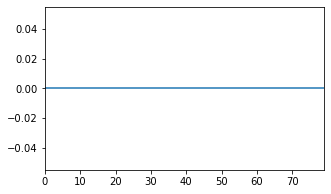

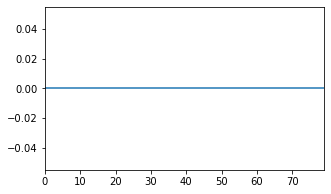

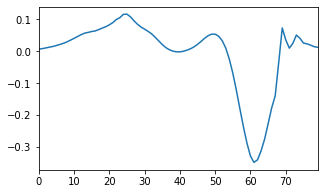

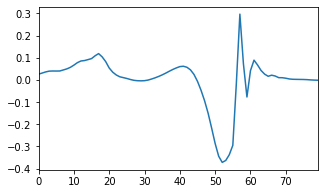

In [ ]:
# adapt this code to your variables

dictionary = d_hat  # add the learned dictionary

for (k, atom) in enumerate(dictionary):
    fig, ax = fig_ax(figsize=(5, 3))
    ax.plot(atom)
    # saving the figure
    plt.savefig(fname=f"figure-question-5-atom-{k}.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

## Question 6

In [ ]:
# use X_test and y_test

index_of_highest_F1 = np.argmax(np.array(list(map(lambda y: f1_score_step_detection(y[0][np.newaxis,:], y[1][np.newaxis,:]), zip(y_test, model.predict(X_test))))))
index_of_lowest_F1 = np.argmin(np.array(list(map(lambda y: f1_score_step_detection(y[0][np.newaxis,:], y[1][np.newaxis,:]), zip(y_test, model.predict(X_test))))))

highest_F1_signal = X_test[index_of_highest_F1]
lowest_F1_signal = X_test[index_of_lowest_F1]

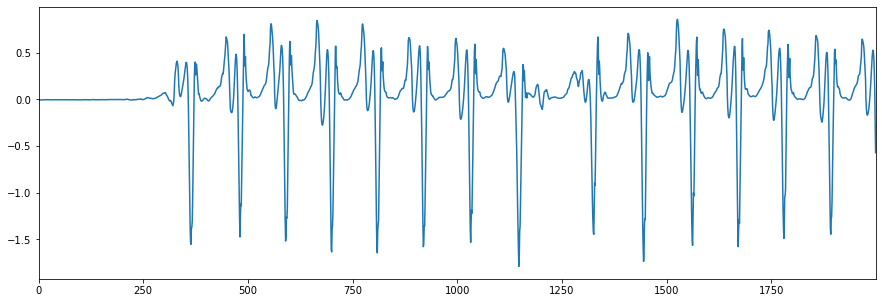

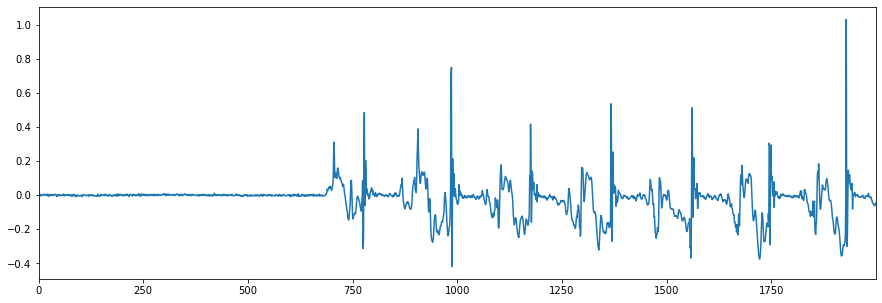

In [ ]:
fig, ax = fig_ax()
ax.plot(highest_F1_signal)
plt.savefig(fname="highest_F1_signal.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

fig, ax = fig_ax()
ax.plot(lowest_F1_signal)
plt.savefig(fname="lowest_F1_signal.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

# Dynamic time warping (DTW)

For this section, the data remain the same but the task is different. We want to classify footsteps in healthy/non-healthy (instead of detecting them as before).

## Data

In [ ]:
subset_indexes = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

fig, ax = fig_ax()
for (step_signal, label) in zip(X_train, y_train):
    color = "b" if label==0 else "r"
    ax.plot(step_signal, color=color, alpha=0.1)

## Question 7

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from dtw import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
# Distance matrix

n = len(X_train)
X = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        X[i, j] = dtw(X_train[i], X_train[j], keep_internals=True).distance

In [ ]:
parameters = {'n_neighbors':np.arange(1,21)}

model = KNeighborsClassifier(metric='precomputed')
scorer = make_scorer(f1_score)

gs = GridSearchCV(model, parameters, scoring=scorer, cv=5, verbose=True)

In [ ]:
gs.fit(X, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(metric='precomputed'),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring=make_scorer(f1_score), verbose=True)

In [ ]:
print("Best parameters set found: %r"%gs.best_params_)
print()
means = gs.cv_results_["mean_test_score"]
stds = gs.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, gs.cv_results_["params"]):
    print("F1 score for %r was: %0.3f (+/-%0.03f)." % (params, mean, std * 2))
    print()

Best parameters set found: {'n_neighbors': 5}

F1 score for {'n_neighbors': 1} was: 0.770 (+/-0.177).

F1 score for {'n_neighbors': 2} was: 0.678 (+/-0.238).

F1 score for {'n_neighbors': 3} was: 0.756 (+/-0.215).

F1 score for {'n_neighbors': 4} was: 0.702 (+/-0.096).

F1 score for {'n_neighbors': 5} was: 0.770 (+/-0.134).

F1 score for {'n_neighbors': 6} was: 0.731 (+/-0.118).

F1 score for {'n_neighbors': 7} was: 0.755 (+/-0.147).

F1 score for {'n_neighbors': 8} was: 0.696 (+/-0.109).

F1 score for {'n_neighbors': 9} was: 0.727 (+/-0.141).

F1 score for {'n_neighbors': 10} was: 0.709 (+/-0.109).

F1 score for {'n_neighbors': 11} was: 0.704 (+/-0.123).

F1 score for {'n_neighbors': 12} was: 0.700 (+/-0.125).

F1 score for {'n_neighbors': 13} was: 0.702 (+/-0.160).

F1 score for {'n_neighbors': 14} was: 0.682 (+/-0.132).

F1 score for {'n_neighbors': 15} was: 0.715 (+/-0.165).

F1 score for {'n_neighbors': 16} was: 0.684 (+/-0.163).

F1 score for {'n_neighbors': 17} was: 0.691 (+/-0.

## Question 8

In [ ]:
model = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
model.fit(X, y_train)
y_pred = model.predict(X)

In [ ]:
healthy_missclassified = X_train[[i for i, (true, pred) in enumerate(zip(y_train, y_pred)) if true==1 and pred==0][0]]
unhealthy_missclassified = X_train[[i for i, (true, pred) in enumerate(zip(y_train, y_pred)) if true==0 and pred==1][0]]

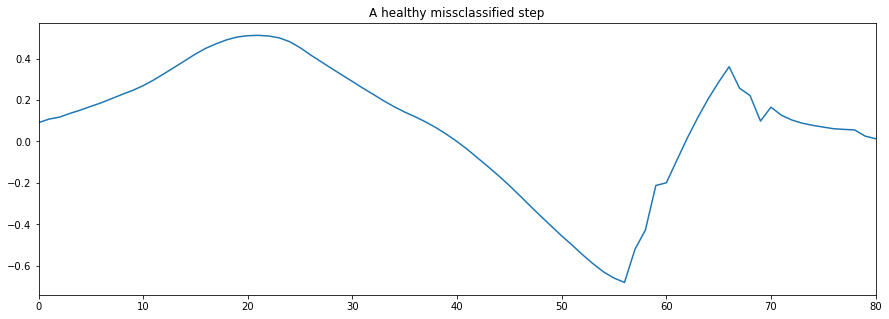

In [ ]:
fig, ax = fig_ax()
ax.plot(healthy_missclassified)
ax.set_title("A healthy missclassified step")
plt.savefig(fname="healthy_missclassified.pdf", transparent=True, bbox_inches="tight", pad_inches=0)

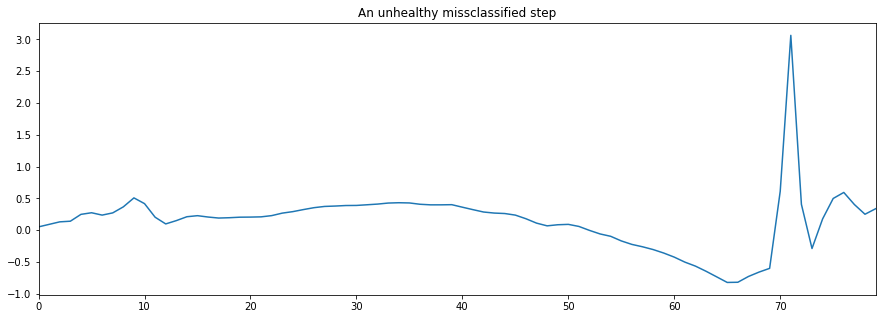

In [ ]:
fig, ax = fig_ax()
ax.plot(unhealthy_missclassified)
ax.set_title("An unhealthy missclassified step")
plt.savefig(fname="unhealthy_missclassified.pdf", transparent=True, bbox_inches="tight", pad_inches=0)